STAT 453: Deep Learning (Spring 2020)
Instructor: Sebastian Raschka (sraschka@wisc.edu)
- Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2020/ 
- GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss20

- Runs on CPU (not recommended here) or GPU (if available)

# VGG16 Convolutional Neural Network

## Imports

In [2]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## Settings and Dataset

In [4]:
##########################
### SETTINGS
##########################

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

# Hyperparameters
random_seed = 1
learning_rate = 0.001
num_epochs = 50
batch_size = 256

# Architecture
num_features = 784
num_classes = 10


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)

test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Device: cuda:0
Files already downloaded and verified
Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])


## Model

In [5]:
##########################
### MODEL
##########################


class VGG16(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(VGG16, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=3,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          # (1(32-1)- 32 + 3)/2 = 1
                          padding=1), 
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(        
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
          
        self.block_4 = nn.Sequential(   
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),    
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))             
        )
            
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            #nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            #nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )
            
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()
                    
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        
    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)

        return logits, probas

    
torch.manual_seed(random_seed)
model = VGG16(num_features=num_features,
              num_classes=num_classes)

model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

## Training

In [6]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss
    

    
minibatch_cost, epoch_cost = [], []
all_train_acc, all_test_acc = [], []

start_time = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        train_acc = compute_accuracy(model, train_loader)
        test_acc = compute_accuracy(model, test_loader)
        print('Epoch: %03d/%03d | Train: %.3f%% | Test: %.3f%%' % (
              epoch+1, num_epochs, train_acc, test_acc))
        
        all_train_acc.append(train_acc)
        all_test_acc.append(test_acc)
        cost = compute_epoch_loss(model, train_loader)
        epoch_cost.append(cost)


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/050 | Batch 0000/0196 | Cost: 2.4017
Epoch: 001/050 | Batch 0050/0196 | Cost: 2.1938
Epoch: 001/050 | Batch 0100/0196 | Cost: 2.0043
Epoch: 001/050 | Batch 0150/0196 | Cost: 1.8046
Epoch: 001/050 | Train: 32.078% | Test: 32.300%
Time elapsed: 0.54 min
Epoch: 002/050 | Batch 0000/0196 | Cost: 1.7706
Epoch: 002/050 | Batch 0050/0196 | Cost: 1.7515
Epoch: 002/050 | Batch 0100/0196 | Cost: 1.7405
Epoch: 002/050 | Batch 0150/0196 | Cost: 1.4079
Epoch: 002/050 | Train: 49.316% | Test: 48.350%
Time elapsed: 1.07 min
Epoch: 003/050 | Batch 0000/0196 | Cost: 1.3884
Epoch: 003/050 | Batch 0050/0196 | Cost: 1.3722
Epoch: 003/050 | Batch 0100/0196 | Cost: 1.2688
Epoch: 003/050 | Batch 0150/0196 | Cost: 1.1689
Epoch: 003/050 | Train: 60.570% | Test: 58.230%
Time elapsed: 1.63 min
Epoch: 004/050 | Batch 0000/0196 | Cost: 1.0885
Epoch: 004/050 | Batch 0050/0196 | Cost: 1.0579
Epoch: 004/050 | Batch 0100/0196 | Cost: 1.2012
Epoch: 004/050 | Batch 0150/0196 | Cost: 0.9914
Epoch: 004/050 | Tr

## Evaluation

In [7]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 77.22%


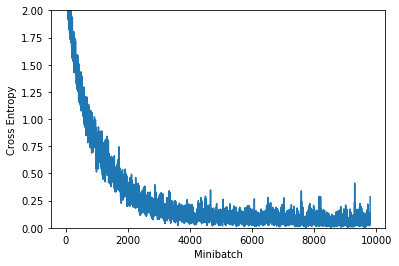

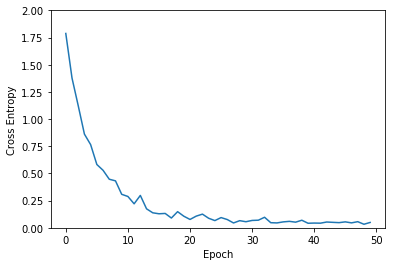

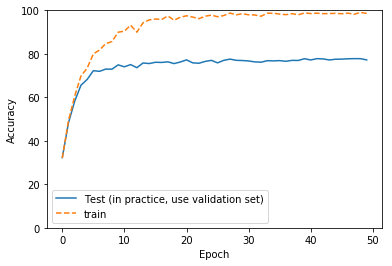

In [8]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.ylim([0, 2])
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.ylim([0, 2])
plt.show()


plt.plot(range(len(all_test_acc)), all_test_acc, label='Test (in practice, use validation set)')
plt.plot(range(len(all_train_acc)), all_train_acc, linestyle='--', label='train')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 100])
plt.legend()
plt.show()